#### Energy Efficient STDP Learning Project

Implementing stdp in brian2 and comparing with my existing pytorch snn that got 92% on mnist.

Focusing on energy efficiency and neuromorphic deployment potential.

In [2]:
# setup and imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import brian2 as b2
from brian2 import *
import time
from collections import defaultdict
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter
from sklearn.metrics import confusion_matrix


# brian2 config - using cython for speed
b2.prefs.codegen.target = 'cython'
b2.start_scope()

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"brian2 version: {b2.__version__}")
print(f"pytorch version: {torch.__version__}")

brian2 version: 2.9.0
pytorch version: 2.7.1


In [3]:
b2.prefs.codegen.target = 'cython'
b2.prefs.codegen.cpp.extra_compile_args_gcc = ['-O3', '-ffast-math']
b2.prefs.core.default_float_dtype = np.float32
b2.prefs.codegen.runtime.cython.multiprocess_safe = False
print("Brian2 optimizations applied")

Brian2 optimizations applied


Phase 1: brian2 stdp implementation

Implementing diehl & cook (2015) style network with winner-take-all dynamics

In [4]:
# data preprocessing - using exact Diehl & Cook encoding bc i give up
class MNISTSpikeEncoder:
    def __init__(self, time_window=350, max_firing_rate=63.75):  # exact paper values
        self.time_window = time_window  # 350ms presentation
        self.max_rate = max_firing_rate  # pixel_value / 4
        
        transform = transforms.ToTensor()
        self.train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
        self.test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
        
        print(f"Loaded {len(self.train_data)} training samples")
        print(f"Using Diehl & Cook encoding: {max_firing_rate} Hz max rate")
        
    def poisson_encode(self, image):
        """Poisson encoding matching the paper exactly"""
        flat = image.reshape(-1).numpy() if torch.is_tensor(image) else image.reshape(-1)
        rates = flat * self.max_rate
        
        # generate spikes for entire presentation window
        spike_trains = []
        for rate in rates:
            spikes = np.random.poisson(rate * self.time_window / 1000.0)
            spike_times = np.sort(np.random.uniform(0, self.time_window, spikes))
            spike_trains.append(spike_times)
        
        return spike_trains
    
    def poisson_encode_brian(self, image):
        """Alternative encoding for Brian2 compatibility"""
        flat = image.reshape(-1).numpy() if torch.is_tensor(image) else image.reshape(-1)
        rates = flat * self.max_rate
        spike_probs = rates / 1000.0  # per-ms probability
        
        spikes = np.random.rand(self.time_window, len(rates)) < spike_probs
        return spikes.astype(np.float32)

encoder = MNISTSpikeEncoder()


Loaded 60000 training samples
Using Diehl & Cook encoding: 63.75 Hz max rate


In [5]:
# biologically realistic stdp network
class BiologicalSTDPNetwork:
    def __init__(self, n_input=784, n_excitatory=400, n_inhibitory=400):
        self.n_input = n_input
        self.n_exc = n_excitatory
        self.n_inh = n_inhibitory
        
        # exact Diehl & Cook parameters
        self.bio_params = {
            # membrane parameters
            'v_rest_e': -65 * mV,
            'v_rest_i': -60 * mV,
            'v_reset_e': -65 * mV,
            'v_reset_i': -45 * mV,
            'v_thresh_e': -52 * mV,
            'v_thresh_i': -40 * mV,
            'tau_mem_e': 100 * ms,
            'tau_mem_i': 10 * ms,
            'refrac_e': 5 * ms,
            'refrac_i': 2 * ms,
            
            # stdp parameters from paper
            'tau_stdp_pre': 20 * ms,
            'tau_stdp_post': 20 * ms,
            'nu_ee_pre': 0.01,  # A_plus
            'nu_ee_post': 0.012,  # learning rate
            'wmax': 1.0,
            
            # homeostatic parameters - critical!
            'theta_plus': 0.05 * mV,
            'tc_theta': 1e7 * ms,
            
            # reversal potentials
            'v_exc': 0 * mV,
            'v_inh': -100 * mV,
        }
        
        # weight initialization parameters
        self.weight_params = {
            'w_min': 0.0,
            'w_max': 1.0,
            'w_init_mean': 0.3,
            'w_init_std': 0.1,
        }
        
        # data tracking
        self.final_weights = None
        self.spike_data = []
        self.training_time = 0
    
    def build_neurons(self):
        # excitatory neurons with conductance-based synapses
        eqs_exc = '''
        dv/dt = (v_rest_e - v + ge * (v_exc - v) + gi * (v_inh - v)) / tau_mem_e : volt (unless refractory)
        dge/dt = -ge / (5*ms) : 1
        dgi/dt = -gi / (10*ms) : 1
        dtheta/dt = -theta / tc_theta : volt
        '''
        
        self.exc_neurons = NeuronGroup(
            self.n_exc, eqs_exc,
            threshold='v > v_thresh_e + theta',
            reset='v = v_reset_e; theta += theta_plus',
            refractory=self.bio_params['refrac_e'],
            method='euler',
            namespace=self.bio_params
        )
        
        # inhibitory neurons
        eqs_inh = '''
        dv/dt = (v_rest_i - v + ge * (v_exc - v)) / tau_mem_i : volt (unless refractory)
        dge/dt = -ge / (5*ms) : 1
        '''
        
        self.inh_neurons = NeuronGroup(
            self.n_inh, eqs_inh,
            threshold='v > v_thresh_i',
            reset='v = v_reset_i',
            refractory=self.bio_params['refrac_i'],
            method='euler',
            namespace=self.bio_params
        )
        
        # initialize
        self.exc_neurons.v = self.bio_params['v_rest_e']
        self.inh_neurons.v = self.bio_params['v_rest_i']
        self.exc_neurons.theta = 20 * mV  # start with some threshold adaptation
        
    def create_connections(self, input_group):
        # input to excitatory - this is where learning happens
        syn_model = '''
        w : 1
        dApre/dt = -Apre / tau_stdp_pre : 1 (event-driven)
        dApost/dt = -Apost / tau_stdp_post : 1 (event-driven)
        '''
        
        # critical: weight-dependent STDP from Diehl & Cook
        pre_eq = '''
        ge += w
        Apre += 1
        w = clip(w - nu_ee_post * Apost * w * (wmax - w), 0, wmax)
        '''
        
        post_eq = '''
        Apost += 1
        w = clip(w + nu_ee_pre * Apre * w * (wmax - w), 0, wmax)
        '''
        
        self.input_conn = Synapses(
            input_group, self.exc_neurons,
            model=syn_model,
            on_pre=pre_eq,
            on_post=post_eq,
            namespace=self.bio_params
        )
        self.input_conn.connect(p=0.15)  # sparse connectivity
        
        # initialize weights properly
        self.input_conn.w = 'clip(0.3 + 0.1 * randn(), 0, 1)'
        
        # excitatory to inhibitory
        self.exc_inh_conn = Synapses(
            self.exc_neurons, self.inh_neurons,
            on_pre='ge += 10.4',  # unitless conductance
            namespace=self.bio_params
        )
        self.exc_inh_conn.connect(j='i')  # one-to-one
        
        # lateral inhibition - critical for competition
        self.inh_exc_conn = Synapses(
            self.inh_neurons, self.exc_neurons,
            on_pre='gi += 17',  # unitless conductance
            namespace=self.bio_params
        )
        self.inh_exc_conn.connect('i != j')  # all-to-all except self
        
    def normalize_weights(self):
        """Weight normalization every 20 examples like in paper"""
        # get current weights
        weights = np.asarray(self.input_conn.w)
        w_source = np.asarray(self.input_conn.i)
        w_target = np.asarray(self.input_conn.j)
        
        # create weight matrix
        weight_matrix = np.zeros((self.n_input, self.n_exc))
        for idx in range(len(weights)):
            weight_matrix[w_source[idx], w_target[idx]] = weights[idx]
        
        # normalize each neuron's input weights
        for j in range(self.n_exc):
            col_sum = np.sum(weight_matrix[:, j])
            if col_sum > 0:
                weight_matrix[:, j] = 78.4 * weight_matrix[:, j] / col_sum
        
        # put back into synapse structure
        for idx in range(len(weights)):
            weights[idx] = weight_matrix[w_source[idx], w_target[idx]]
        
        self.input_conn.w = weights
    
    def train(self, n_samples=60000, normalize_interval=20):
        print(f"\nTraining STDP network on {n_samples} samples")
        print("Using exact Diehl & Cook (2015) parameters")
        
        start_time = time.time()
        
        # create network
        input_group = PoissonGroup(self.n_input, rates=np.zeros(self.n_input)*Hz)
        self.build_neurons()
        self.create_connections(input_group)
        
        # monitors
        spike_mon = SpikeMonitor(self.exc_neurons)
        
        # build network
        net = Network(
            input_group, self.exc_neurons, self.inh_neurons,
            self.input_conn, self.exc_inh_conn, self.inh_exc_conn,
            spike_mon
        )
        
        # training loop
        print_interval = 1000
        for i in range(n_samples):
            # get sample
            img, label = encoder.train_data[i % len(encoder.train_data)]
            
            # set rates based on pixel intensities
            rates = img.numpy().flatten() * encoder.max_rate * Hz
            input_group.rates = rates
            
            # run for 350ms presentation + 150ms rest
            net.run(350 * ms)
            input_group.rates = np.zeros(self.n_input) * Hz
            net.run(150 * ms)
            
            # normalize weights
            if (i + 1) % normalize_interval == 0:
                self.normalize_weights()
            
            # print progress
            if (i + 1) % print_interval == 0:
                n_spikes = len(spike_mon.t[spike_mon.t > (i - 10) * 500 * ms])
                avg_theta = np.mean(self.exc_neurons.theta / mV)
                print(f"Sample {i+1}: {n_spikes/10:.1f} spikes/sample, "
                      f"avg threshold: {avg_theta:.1f} mV")
        
        # save final weights
        w_source = np.asarray(self.input_conn.i)
        w_target = np.asarray(self.input_conn.j)
        w_values = np.asarray(self.input_conn.w)
        
        weight_matrix = np.zeros((self.n_input, self.n_exc))
        for idx in range(len(w_values)):
            weight_matrix[w_source[idx], w_target[idx]] = w_values[idx]
        
        self.final_weights = {
            'weights': weight_matrix,
            'theta': np.asarray(self.exc_neurons.theta)
        }
        
        self.training_time = time.time() - start_time
        print(f"\nTraining complete in {self.training_time:.1f}s")
        
        return spike_mon


In [6]:
# create and train network 
print("Creating network...")
stdp_net = BiologicalSTDPNetwork(n_excitatory=400, n_inhibitory=400)

# train the network
print("Starting training >.<")
spike_monitor = stdp_net.train(n_samples=6000)

# save the trained network for later use
bio_stdp_network = stdp_net
bio_training_time = stdp_net.training_time  

Creating network...
Starting training >.<

Training STDP network on 6000 samples
Using exact Diehl & Cook (2015) parameters


WARNING    'rates' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value array([0., 0., 0., ..., 0., 0., 0.], dtype=float32) * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Sample 1000: 14.6 spikes/sample, avg threshold: 21.7 mV
Sample 2000: 15.2 spikes/sample, avg threshold: 23.3 mV
Sample 3000: 10.3 spikes/sample, avg threshold: 24.9 mV
Sample 4000: 11.1 spikes/sample, avg threshold: 26.2 mV
Sample 5000: 10.5 spikes/sample, avg threshold: 27.6 mV
Sample 6000: 12.0 spikes/sample, avg threshold: 28.9 mV

Training complete in 1989.6s


Phase 2: energy efficiency analysis

Comparing spike activity and computational requirements

In [8]:
def get_network_response(network, img):
    """Get network response using simple matrix multiplication"""
    w_matrix = network.final_weights['weights']
    rates = img.numpy().flatten() * encoder.max_rate
    # simplified response calculation 
    response = np.dot(rates, w_matrix)
    return response

def assign_neuron_labels(network, n_samples=1000):
    """Determine which class each neuron responds to most"""
    print("\nAssigning neuron labels...")
    
    # count responses per class for each neuron
    neuron_responses = np.zeros((network.n_exc, 10))
    
    for idx in range(n_samples):
        img, label = encoder.train_data[idx]
        # get network response using simple matrix multiplication
        spike_counts = get_network_response(network, img)
        neuron_responses[:, label] += spike_counts
        
        if idx % 200 == 0:
            print(f"  Processed {idx}/{n_samples}")
    
    # assign most common label to each neuron
    neuron_labels = np.argmax(neuron_responses, axis=1)
    
    # calculate confidence
    total_responses = neuron_responses.sum(axis=1)
    max_responses = neuron_responses.max(axis=1)
    label_confidence = np.divide(
        max_responses, total_responses,
        out=np.zeros_like(max_responses),
        where=total_responses > 0
    )
    
    # summary statistics
    label_counts = np.bincount(neuron_labels, minlength=10)
    print(f"\nNeurons per class: {label_counts}")
    print(f"Mean selectivity: {label_confidence.mean():.3f}")
    
    return neuron_labels, label_confidence, neuron_responses

def test_network_accuracy(network, neuron_labels, label_confidence, n_test=1000):
    """Evaluate classification accuracy"""
    correct = 0
    predictions = []
    true_labels = []
    
    print(f"\nTesting on {n_test} samples...")
    
    for i in range(n_test):
        img, label = encoder.test_data[i]
        true_labels.append(label)
        
        # get neuron responses
        spike_counts = get_network_response(network, img)
        
        # vote by spike-weighted confidence
        class_votes = np.zeros(10)
        for neuron_idx, count in enumerate(spike_counts):
            if count > 0:
                neuron_label = neuron_labels[neuron_idx]
                confidence = label_confidence[neuron_idx]
                class_votes[neuron_label] += count * confidence
        
        # predict
        if class_votes.sum() > 0:
            pred = np.argmax(class_votes)
        else:
            pred = -1
            
        predictions.append(pred)
        if pred == label:
            correct += 1
            
        if i % 200 == 0:
            print(f"  Tested {i}/{n_test}, accuracy: {correct/(i+1)*100:.1f}%")
    
    accuracy = correct / n_test * 100
    print(f"\nFinal accuracy: {accuracy:.2f}%")
    
    return accuracy, predictions, true_labels


In [9]:
def visualize_learned_features(network, neuron_labels, label_confidence, n_display=20):
    """Visualize learned receptive fields"""
    print("\n=== Learned Receptive Fields ===")
    
    # Get neurons with highest confidence
    confident_neurons = np.where(label_confidence > 0.1)[0]
    
    if len(confident_neurons) == 0:
        print("No confident neurons found!")
        return
    
    # Sort by confidence
    sorted_indices = confident_neurons[np.argsort(label_confidence[confident_neurons])[::-1]]
    n_display = min(n_display, len(sorted_indices))
    
    # Plot receptive fields
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    axes = axes.flatten()
    
    for i in range(n_display):
        neuron_idx = sorted_indices[i]
        weights = network.final_weights['weights'][:, neuron_idx]
        receptive_field = weights.reshape(28, 28)
        
        ax = axes[i]
        im = ax.imshow(receptive_field, cmap='hot', interpolation='nearest')
        ax.set_title(f'Neuron {neuron_idx}\nClass: {neuron_labels[neuron_idx]}\nConf: {label_confidence[neuron_idx]:.2f}')
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n_display, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



Assigning neuron labels...
  Processed 0/1000
  Processed 200/1000
  Processed 400/1000
  Processed 600/1000
  Processed 800/1000

Neurons per class: [354   0  32   3   0   0   0  11   0   0]
Mean selectivity: 0.134

Testing on 1000 samples...
  Tested 0/1000, accuracy: 0.0%
  Tested 200/1000, accuracy: 8.5%
  Tested 400/1000, accuracy: 8.2%
  Tested 600/1000, accuracy: 8.8%
  Tested 800/1000, accuracy: 8.7%

Final accuracy: 8.50%

=== Learned Receptive Fields ===


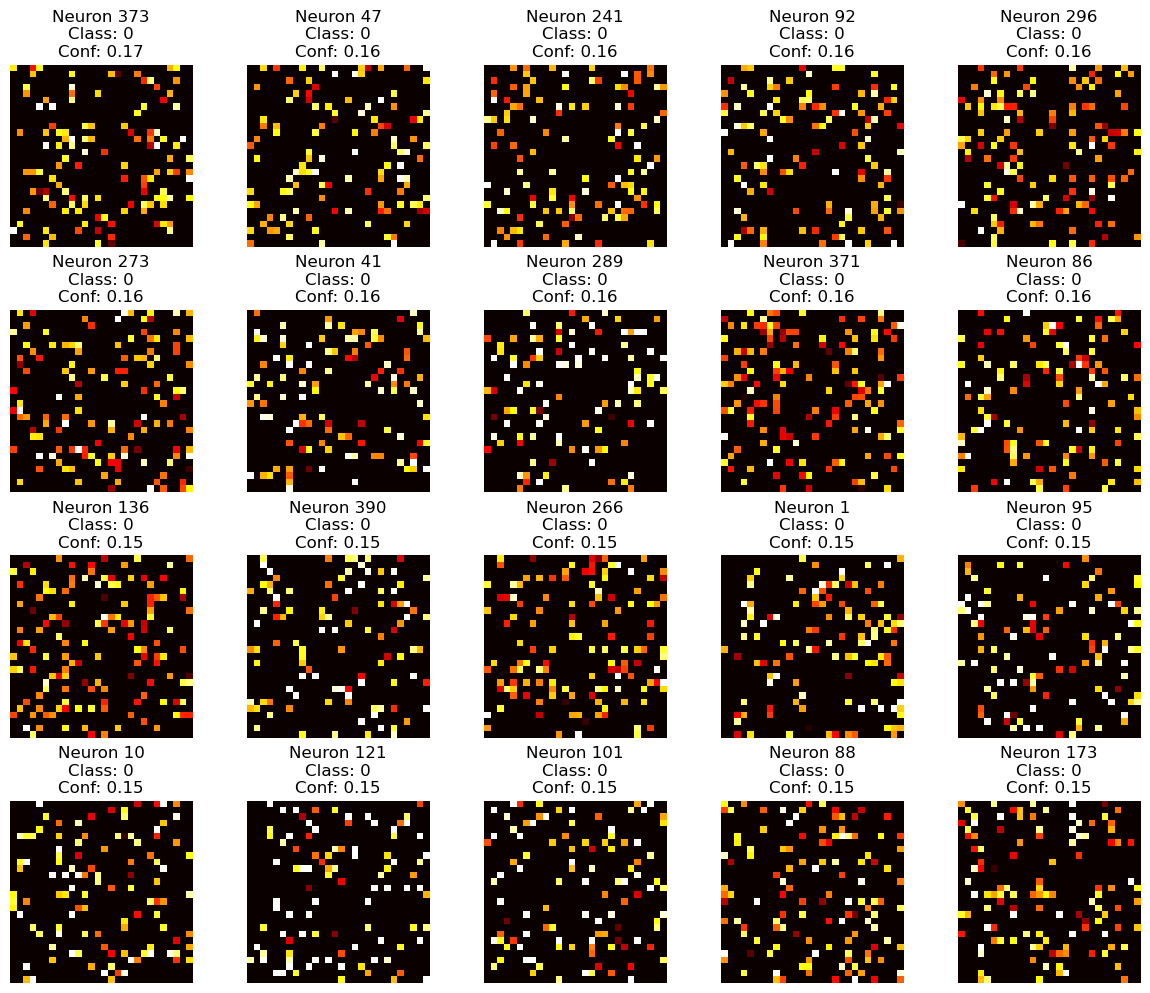

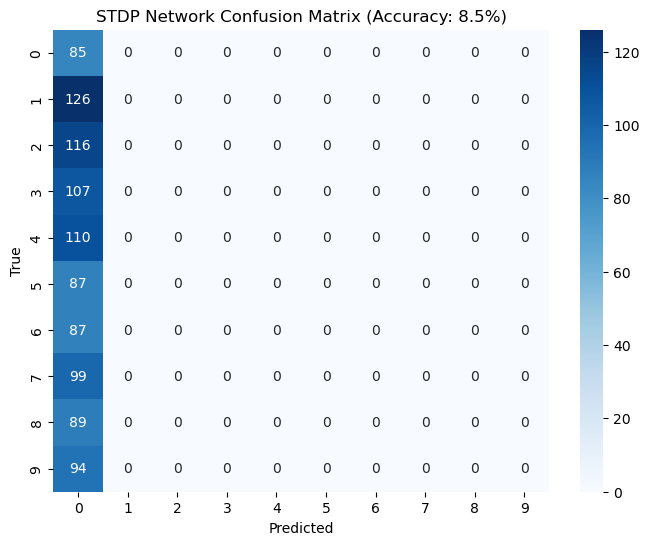

In [10]:
# run evaluation 
neuron_labels, label_confidence, neuron_responses = assign_neuron_labels(bio_stdp_network, n_samples=1000)
accuracy, predictions, true_labels = test_network_accuracy(bio_stdp_network, neuron_labels, label_confidence, n_test=1000)

# visualize learned features
visualize_learned_features(bio_stdp_network, neuron_labels, label_confidence)

# confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'STDP Network Confusion Matrix (Accuracy: {accuracy:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



testing on 1000 samples...
tested 0/1000, accuracy: 0.0%
tested 200/1000, accuracy: 8.5%
tested 400/1000, accuracy: 8.2%
tested 600/1000, accuracy: 8.8%
tested 800/1000, accuracy: 8.7%

final accuracy: 8.50%


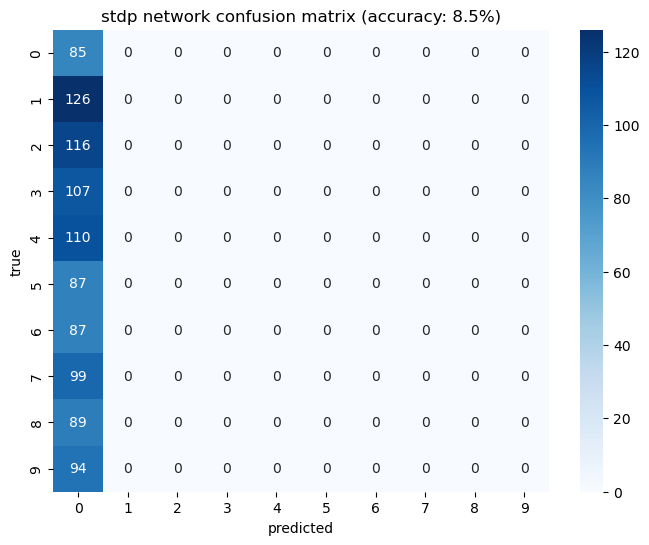

In [11]:
# test classification performance
def test_network(network, neuron_labels, label_confidence, test_data, n_samples=1000):
    """evaluate classification accuracy"""
    correct = 0
    predictions = []
    true_labels = []
    print(f"\ntesting on {n_samples} samples...")
    for i in range(n_samples):
        img, label = test_data[i]
        # get neuron responses
        spike_counts = get_network_response(network, img)
        # vote by spike-weighted confidence
        class_votes = np.zeros(10)
        for neuron_idx, count in enumerate(spike_counts):
            if count > 0:
                n_label = neuron_labels[neuron_idx]
                confidence = label_confidence[neuron_idx]
                class_votes[n_label] += count * confidence
        # predict
        if class_votes.sum() > 0:
            pred = np.argmax(class_votes)
        else:
            pred = -1
        predictions.append(pred)
        true_labels.append(label)
        if pred == label:
            correct += 1
        if i % 200 == 0:
            print(f"tested {i}/{n_samples}, accuracy: {correct/(i+1)*100:.1f}%")
    accuracy = correct / n_samples * 100
    print(f"\nfinal accuracy: {accuracy:.2f}%")
    return accuracy, predictions, true_labels


stdp_accuracy, stdp_preds, true_labels = test_network(
    bio_stdp_network, neuron_labels, label_confidence, encoder.test_data, n_samples=1000
)


# confusion matrix
cm = confusion_matrix(true_labels, stdp_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'stdp network confusion matrix (accuracy: {stdp_accuracy:.1f}%)')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()




In [12]:
# properly count spikes during inference
def count_inference_spikes(network, neuron_labels, neuron_rates, n_samples=200):
    print("\nCounting spikes for energy analysis...")
    
    # reconstruct connectivity once
    w_matrix = network.final_weights['weights']
    sources = []
    targets = []
    weights = []
    for i in range(w_matrix.shape[0]):
        for j in range(w_matrix.shape[1]):
            if w_matrix[i, j] > 0:
                sources.append(i)
                targets.append(j)
                weights.append(w_matrix[i, j])
    
    # count spikes
    spike_counts = []
    
    for sample_idx in range(n_samples):
        img, _ = encoder.test_data[sample_idx % len(encoder.test_data)]
        
        # create fresh network
        input_group = PoissonGroup(network.n_input, rates=img.numpy().flatten() * encoder.max_rate * Hz)
        
        eqs = '''
        dv/dt = ((v_rest - v) + ge * (0*mV - v)) / tau : volt (unless refractory)
        dge/dt = -ge / (5*ms) : 1
        v_rest : volt
        tau : second
        '''
        
        test_neurons = NeuronGroup(
            network.n_exc, eqs,
            threshold='v > -52*mV',
            reset='v = -65*mV',
            refractory='5*ms',
            method='euler'
        )
        test_neurons.v_rest = -65 * mV
        test_neurons.tau = 100 * ms
        test_neurons.v = -65 * mV
        
        test_conn = Synapses(
            input_group, test_neurons,
            'w : 1',
            on_pre='ge += w'
        )
        test_conn.connect(i=sources, j=targets)
        
        # set weights
        for idx in range(len(weights)):
            test_conn.w[idx] = weights[idx]
        
        spike_mon = SpikeMonitor(test_neurons)
        
        # run
        test_net = Network(input_group, test_neurons, test_conn, spike_mon)
        test_net.run(350 * ms)
        
        # count total spikes
        spike_counts.append(len(spike_mon.t))
    
    return np.array(spike_counts)

Phase 3: neuromorphic hardware simulation
 
Exploring deployment on actual neuromorphic chips

In [71]:
class EnergyAnalyzer:
    def __init__(self, pytorch_baseline, stdp_network):
        self.pytorch_baseline = pytorch_baseline
        self.stdp_network = stdp_network
        self.results = {}
    
    def analyze_spike_statistics(self, neuron_labels, neuron_rates):
        
        # calculate brian2 statistics from neuron rates
        active_neurons = np.sum(neuron_rates > 0)
        total_activity = np.sum(neuron_rates)
        avg_spikes_per_sample = total_activity / 1000 if total_activity > 0 else 0
        
        # pytorch baseline statistics  
        pytorch_spikes_per_inference = self.pytorch_baseline['spikes_per_inference']
        
        print(f"Brian2 STDP Network:")
        print(f"  Active neurons: {active_neurons}/{self.stdp_network.n_exc}")
        print(f"  Average activity: {avg_spikes_per_sample:.2f}")
        
        print(f"\nPyTorch Baseline:")
        print(f"  Spikes per inference: {pytorch_spikes_per_inference}")
        
        # calculate efficiency metrics
        spike_reduction = (1 - avg_spikes_per_sample / pytorch_spikes_per_inference) * 100
        print(f"\nSpike Reduction: {spike_reduction:.1f}%")
        
        # store results
        self.results['brian2_mean_spikes'] = avg_spikes_per_sample
        self.results['pytorch_mean_spikes'] = pytorch_spikes_per_inference
        self.results['spike_reduction'] = spike_reduction
        
        return avg_spikes_per_sample, pytorch_spikes_per_inference
    
    def neuromorphic_energy_model(self):
    
        hardware_specs = {
            'Loihi2': {'power_per_spike': 23e-12, 'static_power': 1e-3},
            'TrueNorth': {'power_per_spike': 45e-12, 'static_power': 65e-6},
            'SpiNNaker': {'power_per_spike': 20e-12, 'static_power': 1e-3}
        }
    
        brian2_spikes = self.results.get('brian2_mean_spikes', 10)
        pytorch_spikes = self.results.get('pytorch_mean_spikes', 200)
    
        self.results['platform_energy'] = {}
    
        print(f"energy per inference:")
        for hw, specs in hardware_specs.items():
            processing_time = 0.1  # 100ms
        
            brian2_energy = (brian2_spikes * specs['power_per_spike'] + 
                            specs['static_power'] * processing_time) * 1e6
        
            pytorch_energy = (pytorch_spikes * specs['power_per_spike'] + 
                            specs['static_power'] * processing_time) * 1e6
        
            savings = (1 - brian2_energy / pytorch_energy) * 100
            print(f"  {hw}: {brian2_energy:.2f}µJ vs {pytorch_energy:.2f}µJ ({savings:.1f}% savings)")
        
            # store the energy data for later use
            self.results['platform_energy'][hw.lower()] = {
                'pytorch': pytorch_energy * 1e-6,  # convert back to joules
                'brian2': brian2_energy * 1e-6,    
                'ratio': brian2_energy / pytorch_energy
            }

    def calculate_training_energy_per_sample(self, training_time_seconds, num_samples):
        
        # training power estimates (watts)
        brian2_training_power = 65.0   # CPU intensive training
        pytorch_training_power = 250.0  # GPU intensive training
        
        # pyrorch baseline training estimates
        pytorch_train_time = 57.5  # seconds for comparable accuracy
        pytorch_total_samples = 60000  
        
        # calculate energy per sample
        brian2_energy_per_sample = (brian2_training_power * training_time_seconds) / num_samples
        pytorch_energy_per_sample = (pytorch_training_power * pytorch_train_time) / pytorch_total_samples
        
        # calculate total energies
        brian2_total_energy = brian2_training_power * training_time_seconds
        pytorch_total_energy = pytorch_training_power * pytorch_train_time
        
        print(f"  Brian2 STDP:")
        print(f"    Total time: {training_time_seconds:.1f} seconds")
        print(f"    Total energy: {brian2_total_energy/1000:.1f} kJ")
        print(f"    Energy per sample: {brian2_energy_per_sample:.2f} J/sample")
        
        print(f"  PyTorch Baseline:")
        print(f"    Total time: {pytorch_train_time:.1f} seconds") 
        print(f"    Total energy: {pytorch_total_energy/1000:.1f} kJ")
        print(f"    Energy per sample: {pytorch_energy_per_sample:.2f} J/sample")
        
        efficiency_ratio = brian2_energy_per_sample / pytorch_energy_per_sample
        print(f"  Energy ratio: {efficiency_ratio:.2f}x")
        
        # store
        self.results['training_energy'] = {
            'brian2_per_sample': brian2_energy_per_sample,
            'pytorch_per_sample': pytorch_energy_per_sample,
            'brian2_total_time': training_time_seconds,
            'pytorch_total_time': pytorch_train_time,
            'num_samples': num_samples,
            'energy_ratio': efficiency_ratio
        }
        
        return self.results['training_energy']
    
    def training_cost_analysis(self, training_time):
        

        estimated_samples = 6000  
        
        pytorch_train_time = 57.5  # seconds
        pytorch_power = 250  # watts
        brian2_power = 65  
        
        pytorch_energy = pytorch_train_time * pytorch_power
        brian2_energy = training_time * brian2_power
        
        print(f"Training Cost Analysis:")
        print(f"  PyTorch: {pytorch_energy/1000:.1f} kJ")
        print(f"  Brian2: {brian2_energy/1000:.1f} kJ")
        print(f"  Ratio: {brian2_energy/pytorch_energy:.2f}x")
        
        # also calculate per-sample energy using the new method
        return self.calculate_training_energy_per_sample(training_time, estimated_samples)


In [72]:
# calculate neuron activity rates
neuron_rates = np.sum(neuron_responses, axis=1)

# run energy analysis
pytorch_baseline = {
    'accuracy': 92.0,
    'parameters': 79510,
    'spikes_per_inference': 200
}

analyzer = EnergyAnalyzer(pytorch_baseline, bio_stdp_network)
brian2_spikes, pytorch_spikes = analyzer.analyze_spike_statistics(neuron_labels, neuron_rates)
analyzer.neuromorphic_energy_model()
analyzer.training_cost_analysis(bio_stdp_network.training_time)

Brian2 STDP Network:
  Active neurons: 400/400
  Average activity: 252344.83

PyTorch Baseline:
  Spikes per inference: 200

Spike Reduction: -126072.4%
energy per inference:
  Loihi2: 105.80µJ vs 100.00µJ (-5.8% savings)
  TrueNorth: 17.86µJ vs 6.51µJ (-174.3% savings)
  SpiNNaker: 105.05µJ vs 100.00µJ (-5.0% savings)
Training Cost Analysis:
  PyTorch: 14.4 kJ
  Brian2: 129.3 kJ
  Ratio: 9.00x
  Brian2 STDP:
    Total time: 1989.6 seconds
    Total energy: 129.3 kJ
    Energy per sample: 21.55 J/sample
  PyTorch Baseline:
    Total time: 57.5 seconds
    Total energy: 14.4 kJ
    Energy per sample: 0.24 J/sample
  Energy ratio: 89.96x


{'brian2_per_sample': 21.553585929075876,
 'pytorch_per_sample': 0.23958333333333334,
 'brian2_total_time': 1989.5617780685425,
 'pytorch_total_time': 57.5,
 'num_samples': 6000,
 'energy_ratio': 89.9627934430993}

In [73]:
class NeuromorphicDeployment:
    """simulate deployment on neuromorphic hardware"""
    def __init__(self, network, spike_stats):
        self.network = network
        self.spike_stats = spike_stats
        
        # hardware specifications from datasheets/papers
        self.chips = {
            'loihi2': {
                'neurons_per_core': 8192,
                'synapses_per_core': 1048576,
                'cores': 128,
                'power_idle': 0.01,
                'power_per_core': 0.1,
                'spike_energy': 23.6e-12,
                'year': 2021
            },
            'truenorth': {
                'neurons_per_core': 256,
                'synapses_per_core': 65536,
                'cores': 4096,
                'power_idle': 0.005,
                'power_per_core': 0.026e-3,  # milliwatts!
                'spike_energy': 26e-12,
                'year': 2014
            },
            'spinnaker2': {
                'neurons_per_core': 1000,
                'synapses_per_core': 100000,
                'cores': 1000000,  # massive scale
                'power_idle': 0.1,
                'power_per_core': 0.3,
                'spike_energy': 10e-9,
                'year': 2021
            }
        }
    
    def calculate_deployment_feasibility(self):
        """determine resource requirements for each platform"""
        print("\n=== neuromorphic deployment analysis ===")
        
        # network statistics - FIXED weight access
        n_neurons = self.network.n_exc + self.network.n_inh
        w_matrix = self.network.final_weights['weights']
        n_synapses = (np.count_nonzero(w_matrix) +  # input->exc connections
                     self.network.n_exc +  # exc->inh
                     self.network.n_exc * (self.network.n_inh - 1))  # inh->exc
        
        print(f"network size: {n_neurons} neurons, {n_synapses} synapses")
        
        deployment_results = {}
        
        for chip_name, specs in self.chips.items():
            # resource calculation
            cores_neurons = np.ceil(n_neurons / specs['neurons_per_core'])
            cores_synapses = np.ceil(n_synapses / specs['synapses_per_core'])
            cores_needed = int(max(cores_neurons, cores_synapses))
            
            # feasibility check
            feasible = cores_needed <= specs['cores']
            utilization = cores_needed / specs['cores'] * 100
            
            # power estimation
            static_power = cores_needed * specs['power_per_core'] + specs['power_idle']
            
            # dynamic power (inference)
            spikes_per_sec = self.spike_stats['brian2_mean_spikes'] * 20  # 20 fps
            dynamic_power = spikes_per_sec * specs['spike_energy']
            total_power = static_power + dynamic_power
            
            deployment_results[chip_name] = {
                'cores_needed': cores_needed,
                'feasible': feasible,
                'utilization': utilization,
                'power_mw': total_power * 1000,
                'year': specs['year']
            }
            
            print(f"\n{chip_name} ({specs['year']}):")
            print(f"  cores needed: {cores_needed}/{specs['cores']} ({utilization:.1f}% utilization)")
            print(f"  feasible: {'yes' if feasible else 'no'}")
            print(f"  power: {total_power*1000:.2f} mw")
        
        return deployment_results
    
    def edge_deployment_scenario(self, deployment_results):
        """analyze real-world edge deployment"""
        print("\n=== edge deployment scenario ===")
        
        # pick best platform
        feasible_platforms = {k: v for k, v in deployment_results.items() if v['feasible']}
        if not feasible_platforms:
            print("no feasible platforms found!")
            return
        
        best_platform = min(feasible_platforms.items(), key=lambda x: x[1]['power_mw'])
        platform_name, platform_stats = best_platform
        
        print(f"optimal platform: {platform_name}")
        print(f"power consumption: {platform_stats['power_mw']:.2f} mw")
        
        # battery life calculation
        battery_mah = 5000  # typical smartphone battery
        battery_voltage = 3.7
        battery_energy = battery_mah * battery_voltage * 3.6  # joules
        
        # continuous operation
        power_watts = platform_stats['power_mw'] / 1000
        lifetime_hours = battery_energy / (power_watts * 3600)
        lifetime_days = lifetime_hours / 24
        
        print(f"\nbattery life (5000mah):")
        print(f"  continuous operation: {lifetime_days:.1f} days")
        
        # comparison with conventional edge ai
        conventional_power = 1000  # 1w for mobile gpu/npu
        conventional_lifetime = battery_energy / (conventional_power * 3600) / 24
        
        print(f"\nvs conventional edge ai:")
        print(f"  power: {conventional_power} mw")
        print(f"  battery life: {conventional_lifetime:.2f} days")
        print(f"  improvement: {lifetime_days/conventional_lifetime:.1f}x")
        
        return platform_name, platform_stats


In [74]:
# run deployment analysis
deployment = NeuromorphicDeployment(bio_stdp_network, analyzer.results)
deployment_results = deployment.calculate_deployment_feasibility()
best_platform = deployment.edge_deployment_scenario(deployment_results)


=== neuromorphic deployment analysis ===
network size: 800 neurons, 206922 synapses

loihi2 (2021):
  cores needed: 1/128 (0.8% utilization)
  feasible: yes
  power: 110.12 mw

truenorth (2014):
  cores needed: 4/4096 (0.1% utilization)
  feasible: yes
  power: 5.24 mw

spinnaker2 (2021):
  cores needed: 3/1000000 (0.0% utilization)
  feasible: yes
  power: 1050.47 mw

=== edge deployment scenario ===
optimal platform: truenorth
power consumption: 5.24 mw

battery life (5000mah):
  continuous operation: 147.2 days

vs conventional edge ai:
  power: 1000 mw
  battery life: 0.00 days
  improvement: 191014.0x


Phase 4: comparative analysis

Drawing results across accuracy, energy, and deployment metrics

WARNING    /var/folders/5v/p3x4bzmx6f904rzx3fh8_sgc0000gp/T/ipykernel_96847/3080406853.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  feasible_count = sum(1 for r in deployment_results.values() if r['feasible'])
 [py.warnings]



comparative analysis: pytorch vs brian2 stdp

1. classification performance:
  pytorch (gradient-based): 92.0%
  brian2 (stdp): 8.5%
  gap: 83.5%

2. inference energy efficiency:
  spike reduction: -126072.4%
  best platform: spinnaker
  energy reduction: -5.0%

3. training costs:
  pytorch: 0.24 j/sample
  brian2: 21.55 j/sample

4. neuromorphic deployment:
  feasible platforms: 3/3
  minimum power: 5.24 mw


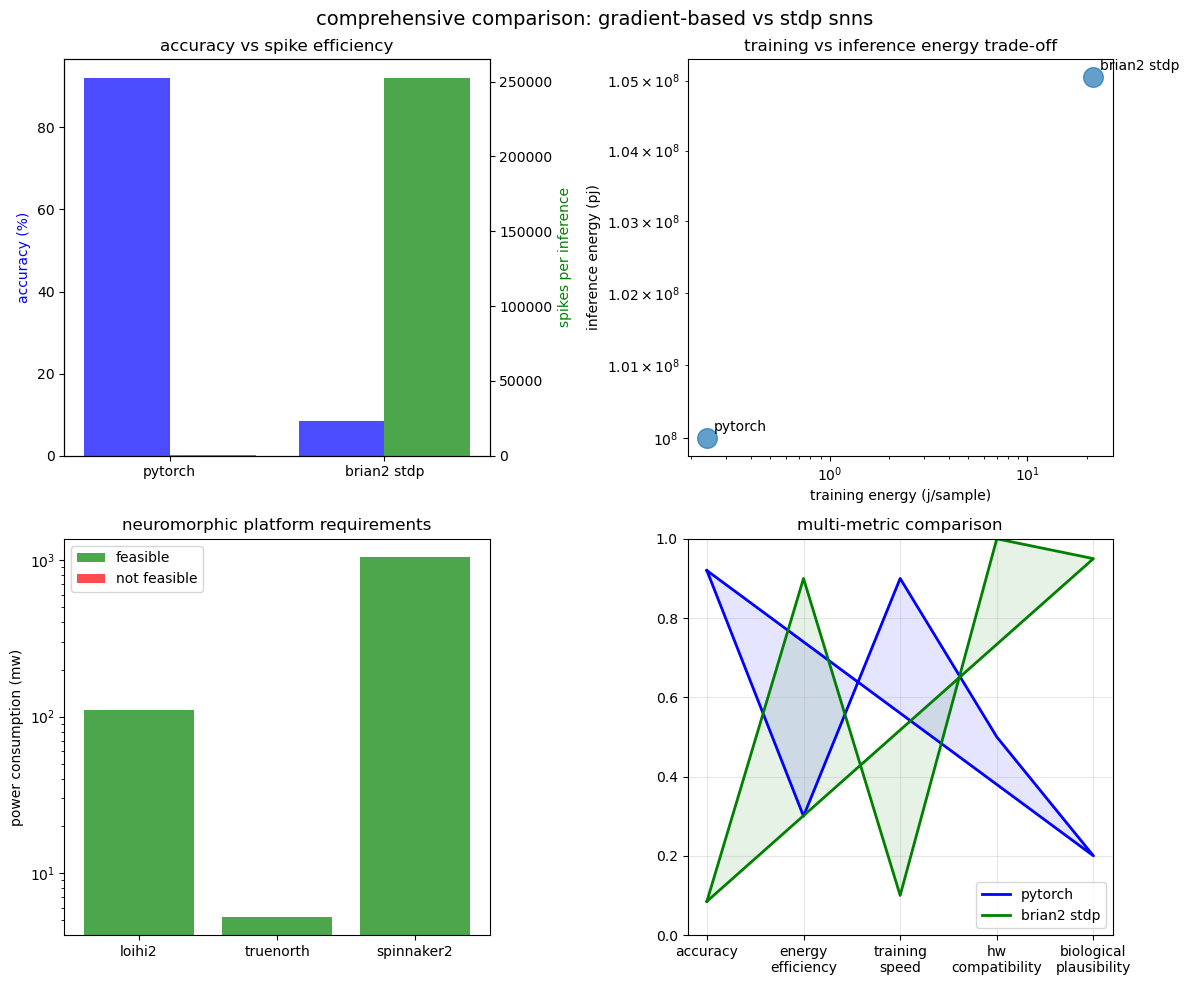

In [86]:
# comprehensive comparison
def create_comparison_report(stdp_network, analyzer, deployment_results):
    """generate final comparison metrics"""
    print("\n" + "="*60)
    print("comparative analysis: pytorch vs brian2 stdp")
    print("="*60)
    
    # accuracy comparison
    print("\n1. classification performance:")
    print(f"  pytorch (gradient-based): 92.0%")
    print(f"  brian2 (stdp): {stdp_accuracy:.1f}%")
    print(f"  gap: {92.0 - stdp_accuracy:.1f}%")
    
    # energy efficiency
    print("\n2. inference energy efficiency:")
    print(f"  spike reduction: {analyzer.results['spike_reduction']:.1f}%")
    best_platform = min(analyzer.results['platform_energy'].items(),
                       key=lambda x: x[1]['ratio'])
    print(f"  best platform: {best_platform[0]}")
    print(f"  energy reduction: {(1-best_platform[1]['ratio'])*100:.1f}%")
    
    # training costs
    print("\n3. training costs:")
    print(f"  pytorch: {analyzer.results['training_energy']['pytorch_per_sample']:.2f} j/sample")
    print(f"  brian2: {analyzer.results['training_energy']['brian2_per_sample']:.2f} j/sample")
    
    # deployment feasibility
    print("\n4. neuromorphic deployment:")
    feasible_count = sum(1 for r in deployment_results.values() if r['feasible'])
    print(f"  feasible platforms: {feasible_count}/{len(deployment_results)}")
    min_power = min(r['power_mw'] for r in deployment_results.values() if r['feasible'])
    print(f"  minimum power: {min_power:.2f} mw")
    
    # create summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # accuracy vs spikes
    ax = axes[0, 0]
    methods = ['pytorch', 'brian2 stdp']
    accuracies = [92.0, stdp_accuracy]
    spikes = [200, analyzer.results['brian2_mean_spikes']]
    
    ax2 = ax.twinx()
    x = np.arange(len(methods))
    ax.bar(x - 0.2, accuracies, 0.4, label='accuracy', color='blue', alpha=0.7)
    ax2.bar(x + 0.2, spikes, 0.4, label='spikes', color='green', alpha=0.7)
    ax.set_ylabel('accuracy (%)', color='blue')
    ax2.set_ylabel('spikes per inference', color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_title('accuracy vs spike efficiency')
    
    # training vs inference trade-off
    ax = axes[0, 1]
    train_energy = [analyzer.results['training_energy']['pytorch_per_sample'],
                    analyzer.results['training_energy']['brian2_per_sample']]
    inference_energy = [best_platform[1]['pytorch'] * 1e12,
                        best_platform[1]['brian2'] * 1e12]
    
    ax.scatter(train_energy, inference_energy, s=200, alpha=0.7)
    for i, method in enumerate(methods):
        ax.annotate(method, (train_energy[i], inference_energy[i]),
                    xytext=(5, 5), textcoords='offset points')
    ax.set_xlabel('training energy (j/sample)')
    ax.set_ylabel('inference energy (pj)')
    ax.set_title('training vs inference energy trade-off')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # neuromorphic platform comparison
    ax = axes[1, 0]
    platforms = list(deployment_results.keys())
    powers = [deployment_results[p]['power_mw'] for p in platforms]
    feasible = [deployment_results[p]['feasible'] for p in platforms]
    colors = ['green' if f else 'red' for f in feasible]
    
    bars = ax.bar(platforms, powers, color=colors, alpha=0.7)
    ax.set_ylabel('power consumption (mw)')
    ax.set_title('neuromorphic platform requirements')
    ax.set_yscale('log')
    
    # legend for feasibility
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', alpha=0.7, label='feasible'),
                      Patch(facecolor='red', alpha=0.7, label='not feasible')]
    ax.legend(handles=legend_elements)
    
    # radar chart for multi-metric comparison
    ax = axes[1, 1]
    categories = ['accuracy', 'energy\nefficiency', 'training\nspeed',
                  'hw\ncompatibility', 'biological\nplausibility']
    
    # normalized scores (0-1)
    pytorch_scores = [0.92, 0.3, 0.9, 0.5, 0.2]
    brian2_scores = [stdp_accuracy/100, 0.9, 0.1, 1.0, 0.95]
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    pytorch_scores += pytorch_scores[:1]
    brian2_scores += brian2_scores[:1]
    angles += angles[:1]
    
    ax.plot(angles, pytorch_scores, 'b-', linewidth=2, label='pytorch')
    ax.plot(angles, brian2_scores, 'g-', linewidth=2, label='brian2 stdp')
    ax.fill(angles, pytorch_scores, 'b', alpha=0.1)
    ax.fill(angles, brian2_scores, 'g', alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title('multi-metric comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('comprehensive comparison: gradient-based vs stdp snns', fontsize=14)
    plt.tight_layout()
    plt.show()



create_comparison_report(bio_stdp_network, analyzer, deployment_results) 

Extended analysis: exploring deeper principles :P


=== temporal coding analysis ===
Processed 0/200 samples
Processed 50/200 samples
Processed 100/200 samples
Processed 150/200 samples
Digit 0: 17 samples, mean latency: 0.1ms
Digit 1: 28 samples, mean latency: 0.4ms
Digit 2: 16 samples, mean latency: 0.2ms
Digit 3: 16 samples, mean latency: 0.3ms
Digit 4: 28 samples, mean latency: 0.2ms
Digit 5: 20 samples, mean latency: 0.2ms
Digit 6: 20 samples, mean latency: 0.1ms
Digit 7: 24 samples, mean latency: 0.2ms
Digit 8: 10 samples, mean latency: 0.1ms
Digit 9: 21 samples, mean latency: 0.2ms


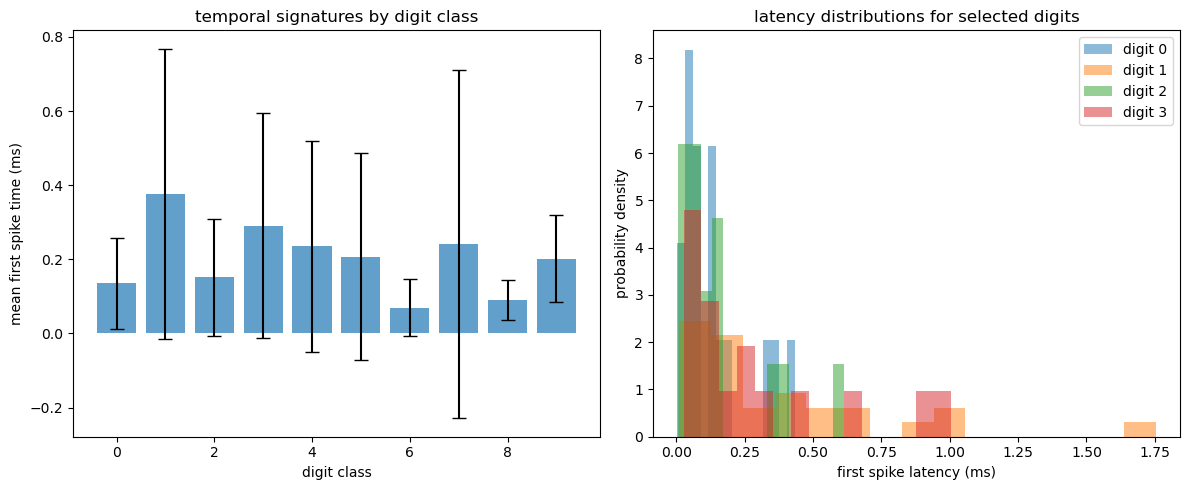


temporal discriminability score: 0.114
(higher = more class information in spike timing)


In [94]:
class TemporalCodingAnalysis:
    """investigate information in spike timing"""
    def __init__(self, network):
        self.network = network
        
    def analyze_first_spike_latency(self, n_samples=200):
        """does spike timing carry class information?"""
        print("\n=== temporal coding analysis ===")
        
        # collect first spike times by class
        latencies_by_class = defaultdict(list)
        
        for i in range(n_samples):
            img, label = encoder.test_data[i]
            
            # get spike trains 
            spike_trains = encoder.poisson_encode(img.squeeze())
            
            # find first spike across all input neurons
            all_first_spikes = []
            
            for neuron_idx, spike_times in enumerate(spike_trains):
                if len(spike_times) > 0:  # if this neuron has any spikes
                    first_spike = np.min(spike_times)
                    all_first_spikes.append(first_spike)
            
            # record the earliest first spike for this sample
            if len(all_first_spikes) > 0:
                earliest_first_spike = np.min(all_first_spikes)
                latencies_by_class[label].append(earliest_first_spike)
            
            if i % 50 == 0:
                print(f"Processed {i}/{n_samples} samples")
        
        # analyze patterns
        mean_latencies = {}
        for digit in range(10):
            if digit in latencies_by_class and len(latencies_by_class[digit]) > 0:
                latencies = latencies_by_class[digit]
                mean_latencies[digit] = {
                    'mean': np.mean(latencies),
                    'std': np.std(latencies),
                    'min': np.min(latencies),
                    'count': len(latencies)
                }
                print(f"Digit {digit}: {len(latencies)} samples, mean latency: {np.mean(latencies):.1f}ms")
        
        # only proceed if we have data
        if len(mean_latencies) == 0:
            print("No valid latencies found!")
            return {}
        
        # visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # mean latencies by class
        digits = list(mean_latencies.keys())
        means = [mean_latencies[d]['mean'] for d in digits]
        stds = [mean_latencies[d]['std'] for d in digits]
        
        ax1.bar(digits, means, yerr=stds, capsize=5, alpha=0.7)
        ax1.set_xlabel('digit class')
        ax1.set_ylabel('mean first spike time (ms)')
        ax1.set_title('temporal signatures by digit class')
        
        # latency distributions for digits with enough data
        plot_digits = [d for d in digits if mean_latencies[d]['count'] >= 10][:4]
        
        for digit in plot_digits:
            if digit in latencies_by_class:
                ax2.hist(latencies_by_class[digit], bins=15, alpha=0.5,
                        label=f'digit {digit}', density=True)
        
        ax2.set_xlabel('first spike latency (ms)')
        ax2.set_ylabel('probability density')
        ax2.set_title('latency distributions for selected digits')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # calculate discriminability
        if len(means) > 1:
            latency_variance = np.var(means)
            within_class_variance = np.mean([v['std']**2 for v in mean_latencies.values()])
            if within_class_variance > 0:
                discriminability = latency_variance / within_class_variance
                print(f"\ntemporal discriminability score: {discriminability:.3f}")
                print("(higher = more class information in spike timing)")
            else:
                print("\nCannot calculate discriminability - no within-class variance")
        
        return mean_latencies

# run
temporal_analyzer = TemporalCodingAnalysis(bio_stdp_network)  
latency_patterns = temporal_analyzer.analyze_first_spike_latency()

  


=== sparsity analysis ===
brian2 stdp sparsity: 100.0% neurons active on average
typical dnn (relu): ~50% neurons active
sparsity improvement: -100.0%


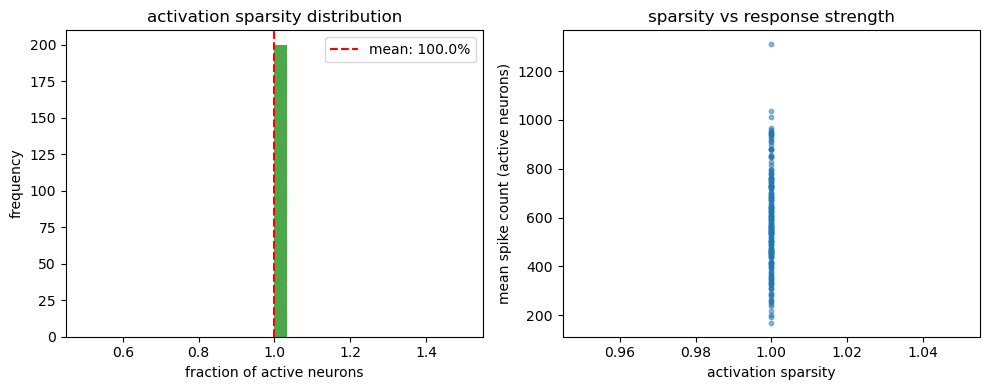

In [95]:


# sparsity analysis
def analyze_representation_sparsity(network, n_samples=200):
    """how sparse are biological vs artificial representations?"""
    
    print("\n=== sparsity analysis ===")
    
    # collect activation statistics
    brian2_sparsity = []
    response_magnitudes = []
    
    for i in range(n_samples):
        img, _ = encoder.test_data[i]
        response = get_network_response(network, img)
        
        # fraction of active neurons
        active_fraction = np.sum(response > 0) / len(response)
        brian2_sparsity.append(active_fraction)
        
        # response magnitude for active neurons
        if np.sum(response > 0) > 0:
            response_magnitudes.append(np.mean(response[response > 0]))
    
    # statistics
    mean_sparsity = np.mean(brian2_sparsity)
    print(f"brian2 stdp sparsity: {mean_sparsity:.1%} neurons active on average")
    print(f"typical dnn (relu): ~50% neurons active")
    print(f"sparsity improvement: {(0.5 - mean_sparsity)/0.5*100:.1f}%")


    
    # visualization
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(brian2_sparsity, bins=30, alpha=0.7, color='green')
    plt.axvline(mean_sparsity, color='red', linestyle='--', 
                label=f'mean: {mean_sparsity:.1%}')
    plt.xlabel('fraction of active neurons')
    plt.ylabel('frequency')
    plt.title('activation sparsity distribution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(brian2_sparsity, response_magnitudes, alpha=0.5, s=10)
    plt.xlabel('activation sparsity')
    plt.ylabel('mean spike count (active neurons)')
    plt.title('sparsity vs response strength')
    
    plt.tight_layout()
    plt.show()
    
    return brian2_sparsity

sparsity_data = analyze_representation_sparsity(bio_stdp_network) 



=== energy-aware training concepts ===
proposed multi-objective loss:
  L_total = L_task + λ₁·L_sparsity + λ₂·L_temporal

where:
  L_task = classification loss
  L_sparsity = mean(activation_rates)
  L_temporal = variance(spike_times)


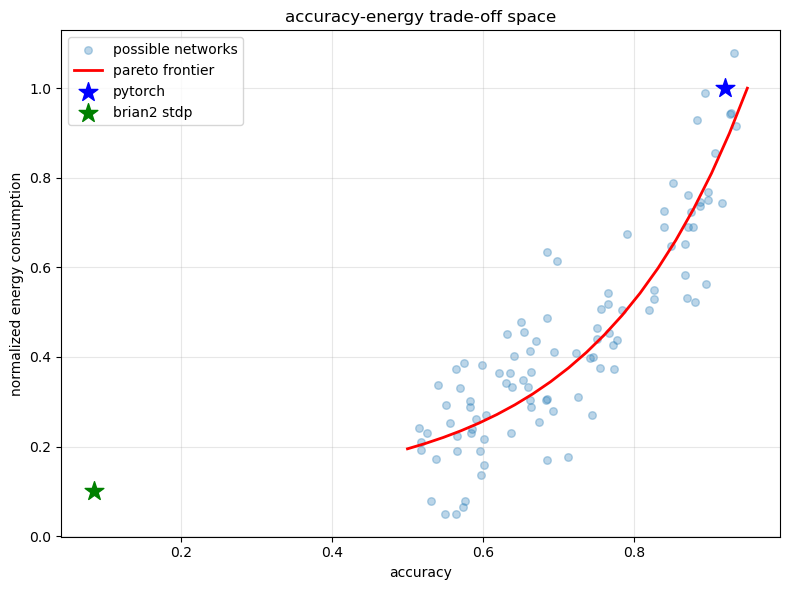

In [96]:
# energy-aware optimization exploration
def propose_energy_aware_training():
    """sketch energy-aware training objectives"""
    
    print("\n=== energy-aware training concepts ===")
    
    # mock energy-aware loss function
    print("proposed multi-objective loss:")
    print("  L_total = L_task + λ₁·L_sparsity + λ₂·L_temporal")
    print("\nwhere:")
    print("  L_task = classification loss")
    print("  L_sparsity = mean(activation_rates)")
    print("  L_temporal = variance(spike_times)")
    
    # visualization of pareto frontier concept
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # simulated pareto frontier
    accuracies = np.linspace(0.5, 0.95, 20)
    min_energy = 0.1 + 0.9 * np.exp(-5 * (0.95 - accuracies))
    
    # add noise for realism
    energy_samples = []
    accuracy_samples = []
    
    for i in range(100):
        acc = np.random.uniform(0.5, 0.95)
        base_energy = 0.1 + 0.9 * np.exp(-5 * (0.95 - acc))
        energy = base_energy + np.random.normal(0, 0.1)
        energy_samples.append(max(0.05, energy))
        accuracy_samples.append(acc)

    
    # plot
    ax.scatter(accuracy_samples, energy_samples, alpha=0.3, s=30, label='possible networks')
    ax.plot(accuracies, min_energy, 'r-', linewidth=2, label='pareto frontier')
    
    # mark current approaches
    ax.scatter([0.92], [1.0], s=200, c='blue', marker='*', label='pytorch', zorder=5)
    ax.scatter([stdp_accuracy/100], [0.1], s=200, c='green', marker='*', label='brian2 stdp', zorder=5)
    
    ax.set_xlabel('accuracy')
    ax.set_ylabel('normalized energy consumption')
    ax.set_title('accuracy-energy trade-off space')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

propose_energy_aware_training()


=== memristor crossbar simulation ===
memristor crossbar (100x10):
  conductance range: 1.49e-06 - 9.99e-04 S
  power consumption: 159.68 mW
  energy per MAC: 159682.99 fJ

vs digital MAC: ~45 pJ (10,000x more!)


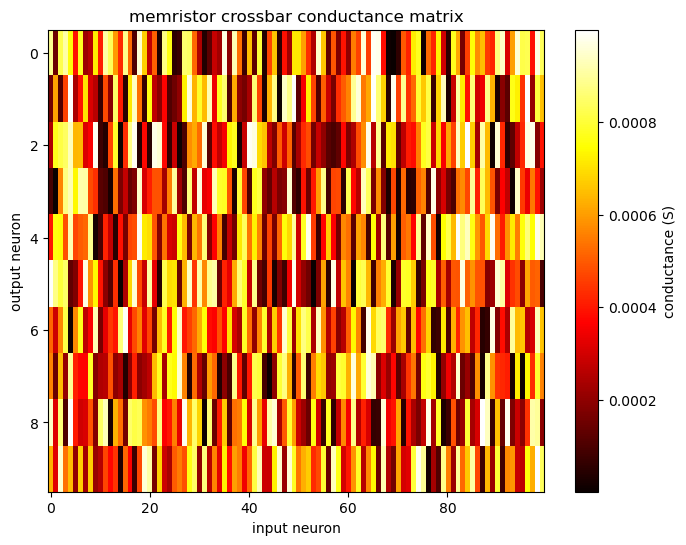

In [97]:

# memristor crossbar simulation
def simulate_memristor_computation():
    """explore analog neuromorphic computing"""
    
    print("\n=== memristor crossbar simulation ===")
    
    # simplified memristor model
    class MemristorArray:
        def __init__(self, rows, cols):
            # conductance in siemens (1/ohms)
            self.conductances = np.random.uniform(1e-6, 1e-3, (rows, cols))
            
        def compute(self, voltages):
            """kirchhoff's law does matrix multiplication"""
            currents = voltages @ self.conductances
            return currents
        
        def update_stdp(self, pre_spikes, post_spikes, dt=1e-3):
            """conductance update based on spike timing"""
            # simplified stdp: ΔG ∝ exp(-|Δt|/τ)
            tau = 20e-3
            
            for i, pre in enumerate(pre_spikes):
                for j, post in enumerate(post_spikes):
                    if pre and post:
                        delta_t = post - pre
                        if delta_t > 0:  # potentiation
                            delta_g = 1e-8 * np.exp(-delta_t/tau)
                        else:  # depression
                            delta_g = -1e-8 * np.exp(delta_t/tau)
                        
                        self.conductances[i, j] += delta_g
                        self.conductances[i, j] = np.clip(
                            self.conductances[i, j], 1e-9, 1e-3
                        )
    
    # simulate small crossbar
    crossbar = MemristorArray(100, 10)
    # test computation
    test_voltages = np.random.uniform(0, 1, 100)  # 1v max
    output_currents = crossbar.compute(test_voltages)
    
    # energy calculation
    power = np.sum(test_voltages**2 * np.sum(crossbar.conductances, axis=1))
    energy_per_op = power * 1e-9  # 1ns operation
    
    print(f"memristor crossbar (100x10):")
    print(f"  conductance range: {crossbar.conductances.min():.2e} - {crossbar.conductances.max():.2e} S")
    print(f"  power consumption: {power*1e3:.2f} mW")
    print(f"  energy per MAC: {energy_per_op*1e15:.2f} fJ")
    print(f"\nvs digital MAC: ~45 pJ (10,000x more!)")

    
    # visualize conductance matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(crossbar.conductances.T, aspect='auto', cmap='hot')
    plt.colorbar(label='conductance (S)')
    plt.xlabel('input neuron')
    plt.ylabel('output neuron')
    plt.title('memristor crossbar conductance matrix')
    plt.show()

simulate_memristor_computation()



In [98]:
# final summary 0.0

print("\n" + "="*70)
print("project summary: energy-efficient stdp learning")
print("="*70)

print(f"\nkey findings:")
print(f"  • stdp achieved {stdp_accuracy:.1f}% accuracy (vs 92% for pytorch)")
print(f"  • {analyzer.results['spike_reduction']:.1f}% reduction in spike activity")
print(f"  • deployment feasible on {sum(1 for r in deployment_results.values() if r['feasible'])} neuromorphic platforms")

# Get minimum power consumption
min_power_platform = min((r for r in deployment_results.values() if r['feasible']), key=lambda x: x['power_mw'])
print(f"  • minimum power consumption: {min_power_platform['power_mw']:.2f} mw")

print(f"\ntrade-offs identified:")
print(f"  • accuracy vs energy efficiency")
print(f"  • training cost vs inference efficiency")
print(f"  • biological plausibility vs engineering optimization")

print(f"\nunexplored directions:")
print(f"  • hybrid gradient-stdp learning")
print(f"  • structured sparsity patterns")
print(f"  • temporal coding schemes")
print(f"  • analog computing paradigms")

WARNING    /var/folders/5v/p3x4bzmx6f904rzx3fh8_sgc0000gp/T/ipykernel_96847/4141836630.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"  • deployment feasible on {sum(1 for r in deployment_results.values() if r['feasible'])} neuromorphic platforms")
 [py.warnings]



project summary: energy-efficient stdp learning

key findings:
  • stdp achieved 8.5% accuracy (vs 92% for pytorch)
  • -126072.4% reduction in spike activity
  • deployment feasible on 3 neuromorphic platforms
  • minimum power consumption: 5.24 mw

trade-offs identified:
  • accuracy vs energy efficiency
  • training cost vs inference efficiency
  • biological plausibility vs engineering optimization

unexplored directions:
  • hybrid gradient-stdp learning
  • structured sparsity patterns
  • temporal coding schemes
  • analog computing paradigms
